In [1]:
import jax
import jax.numpy as jnp
import optax
import flax
import math 
import random

from matplotlib import pyplot as plt

from flax.training import train_state
from flax.training.common_utils import get_metrics, onehot, shard

import numpy as np

from tqdm.notebook import tqdm

from transformers import FlaxAutoModelForCausalLM
from transformers import AutoTokenizer

from datasets import Dataset

In [2]:
MAX_SEQ_LENGTH = 9
TRAINING_SEED = 20
BATCH_SIZE = 512

In [3]:
model = FlaxAutoModelForCausalLM.from_pretrained("distilgpt2", 
                                        seed=TRAINING_SEED, 
                                        dtype=jnp.dtype("bfloat16"))

In [4]:
tokenizer = AutoTokenizer.from_pretrained(
    "../tokenizer/tokenizer_40000"
)
print(tokenizer.eos_token)

<|endoftext|>


In [5]:
seq1 = "1 2 3 4 5 6 7 8"
seq2 = "a b c d e f g h"
seq3 = "h g f e d c b a"
print(tokenizer(seq1).tokens())
print(tokenizer(seq2).tokens())
print(tokenizer(seq3).tokens())

data_list = [seq1 for _ in range(1024)]
data_list += [seq2 for _ in range(1024)]
data_list += [seq3 for _ in range(1024)]

random.shuffle(data_list)

data_dict = {"text": data_list}

dataset = Dataset.from_dict(data_dict)

['1', 'Ġ2', 'Ġ3', 'Ġ4', 'Ġ5', 'Ġ6', 'Ġ7', 'Ġ8']
['a', 'Ġb', 'Ġc', 'Ġd', 'Ġe', 'Ġf', 'Ġg', 'Ġh']
['h', 'Ġg', 'Ġf', 'Ġe', 'Ġd', 'Ġc', 'Ġb', 'Ġa']


I want my dataset iterator to take in parameters (dataset, tokenizer, number of training tokens, batch_size, seqlen). 

In [6]:
from itertools import islice
import sys

# this toy dataset assumes all dataset examples are exactly `seqlen` 
# long when tokenized and that batch_size divides training_tokens
class ToyDataIterator(): 
    def __init__(self, dataset, tokenizer, training_tokens, 
                seqlen, batch_size, seed): 
        self.tokenizer = tokenizer
        self.dataset = dataset
        self.seqlen = seqlen
        self.training_tokens = training_tokens
        self.batch_size = batch_size
        self.seed = seed
        
    def __iter__(self): 
        # keeps looping until number of training tokens reached
        tokens_so_far = 0 
        while True: 
            iterator = iter(self.dataset.shuffle(seed=self.seed))
            self.seed += 1
            while any(iterator): 
                batch = list(islice(iterator, self.batch_size))
                tokens = tokenizer([x["text"] for x in batch],
                                  max_length=self.seqlen, 
                                  truncation=True)
                yield shard(jnp.array(tokens["input_ids"]))
                tokens_so_far += self.batch_size*self.seqlen
                if tokens_so_far > self.training_tokens: 
                    return

In [7]:
iterator = ToyDataIterator(dataset, tokenizer, training_tokens=2**20, 
                          seqlen=8, batch_size=512, seed=20)

for _ in tqdm(iterator): 
    pass

for x in tqdm(iterator): 
    print(x)
    break

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[[[  17  476  715 ... 1396 1761 1776]
  [  65  313  278 ...  283  353  440]
  [  17  476  715 ... 1396 1761 1776]
  ...
  [  65  313  278 ...  283  353  440]
  [  72  353  283 ...  278  313  262]
  [  72  353  283 ...  278  313  262]]]


# Pretraining loop

In [8]:
per_device_batch_size = 256
num_epochs = 10
training_seed = 0
learning_rate = 3e-4
alpha = 0.1
training_tokens = 2 ** 20
warmup_steps = 200
eval_steps = 256
seq_length = 8

total_batch_size = per_device_batch_size * jax.device_count()
training_steps = math.ceil(
    training_tokens/(total_batch_size*seq_length))

print("devices: ", jax.device_count())
print("training steps: ", training_steps)
print("warmup steps: ", warmup_steps)
print("evaluation steps: ", eval_steps)

devices:  1
training steps:  512
warmup steps:  200
evaluation steps:  256


Defines the learning rate schedule and optimizer

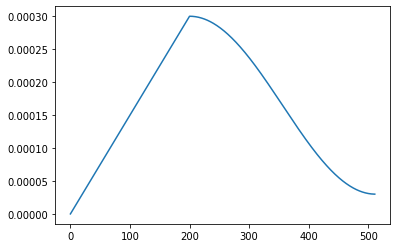

In [9]:
warmup_fn = optax.linear_schedule(init_value=0.0,
                                 end_value=learning_rate, 
                                 transition_steps=warmup_steps)

decay_fn = optax.cosine_decay_schedule(init_value=learning_rate, 
                            decay_steps = training_steps-warmup_steps,
                            alpha=alpha)

schedule_fn = optax.join_schedules(schedules=[warmup_fn, decay_fn], 
                                  boundaries=[warmup_steps])

values = [schedule_fn(i) for i in range(training_steps)]
plt.plot(values)
plt.show()

optimizer = optax.adamw(learning_rate = schedule_fn, 
                       b1=0.9, b2=0.98, eps=1e-8, 
                       weight_decay=0.01)

In [10]:
state = train_state.TrainState.create(apply_fn=model.__call__, 
                                     params=model.params, 
                                     tx=optimizer)

In [11]:
def train_step(state, batch, dropout_rng): 
    dropout_rng, new_dropout_rng = jax.random.split(dropout_rng)
    
    def loss_fn(params): 
        logits = state.apply_fn(batch, 
                               params=params, 
                               dropout_rng=dropout_rng,
                               train=True)[0]
        loss = optax.softmax_cross_entropy(logits[..., :-1, :],
               onehot(batch[..., 1:], logits.shape[-1])).mean()
        return loss
        
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grad = grad_fn(state.params)
    grad = jax.lax.pmean(grad, "batch")
    new_state = state.apply_gradients(grads=grad)
        
    metrics = jax.lax.pmean(
           {"loss": loss, 
            "learning_rate": schedule_fn(state.step)}, 
           axis_name = "batch"
    )
    
    return new_state, metrics, new_dropout_rng

In [12]:
def eval_step(params, batch): 
    logits = model(batch, params=params, train=False)[0]
    
    loss = optax.softmax_cross_entropy(logits[..., :-1, :], 
               onehot(labels[..., 1:], logits.shape[-1])).mean()
    
    metrics = {"loss": loss, "perplexity": jnp.exp(loss)}
    return metrics

In [13]:
parallel_train_step = jax.pmap(train_step, "batch")
parallel_eval_step = jax.pmap(eval_step, "batch")
state = flax.jax_utils.replicate(state)

rng = jax.random.PRNGKey(TRAINING_SEED)
dropout_rngs = jax.random.split(rng, jax.local_device_count())

Now here is the training script

In [ ]:
train_loader = ToyDataIterator(dataset, tokenizer, 
                               training_tokens=training_tokens, 
                               seqlen=seq_length, 
                               batch_size=total_batch_size, 
                               seed=TRAINING_SEED)

eval_loader = ToyDataIterator(dataset, tokenizer, 
                             training_tokens=2**6, 
                             seqlen=seq_length, 
                             batch_size=total_batch_size, 
                             seed=TRAINING_SEED)

for i, batch in tqdm(enumerate(train_loader), total=training_steps): 
    rng, input_rng = jax.random.split(rng)
    
    state, train_metric, dropout_rngs = parallel_train_step(state, 
                                                        batch, 
                                                        dropout_rngs)
    
    if i % eval_steps==0 and i > 0: 
        print(f"evaluating at step {i}...")
        eval_metrics = []
        eval_metric = parallel_eval_step(state.params, batch)
        
        for batch in eval_loader: 
            eval_metric = parallel_eval_step(state.params, batch)
            eval_metrics.append(eval_metric)
            
        eval_metrics = get_metrics(eval_metrics)
        eval_metrics = jax.tree_map(jnp.mean, eval_metrics)
        
        print(eval_metrics)
        
        
    

  0%|          | 0/512 [00:00<?, ?it/s]